#  Machine learning assisted sensing of biomolecules by means of Raman spectroscopy

## Concentration of active substance in different pharmaceutical tablets

The matter of interest in the original article for this dataset was to obtain the active substance content of a pharmaceutical tablet. The dataset is available through a public chemometrics and spectroscopy data repository and is the data used for the article written by M. Dyrby et al.

The tablets were Escitalopram® and had four different dosages (5 mg that corresponds to 5.6 %w/w in active substance per tablet; and 10, 15, and 20 mg that correspond to 8.0% w/w.

The tablets contained several excipients, including microcrystalline cellulose at around 80%, and minor excipients like magnesium stearate, talc, and a coating material containing titanium dioxide.

Data: http://www.models.life.ku.dk/Tablets

### Read the samples
The samples are contained in a single file, it also contains the reference value for predicting on it under the `active (% w/w)` column.

To read the data we first need to create an Spectra object, which will contain all the spectroscopy samples and which contains the pre-processing methods, and then use the readFile method specifying the Spectra object in which to put the spectroscopy data.

```
spectra = rpy.Spectra()
to_predict = rpy.readFile(source_file, spectra_object, contains_reference_values)
```

**Note: these can be read like this because this specific structure of MATLAB data was implemented, however, for other MATLAB structures it's highly possible it won't work**

In [2]:
# Needed libraries
import matplotlib.pyplot as plt
import numpy as np
import ramanpy as rpy
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math
import warnings
warnings.filterwarnings("ignore") # To ignore annoying warnings on deprecations that third-party libraries perform

C:\Users\frabb\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
spectra = rpy.Spectra()
to_predict = rpy.readFile("measurements/Ramandata_tablets.MAT", spectra, True)

+----------------+------+----------+----------+----------+-----+----------+----------+----------+----------+----------+
| active (% w/w) | Type | 3600.000 | 3599.000 | 3598.000 | ... | 204.0000 | 203.0000 | 202.0000 | 201.0000 | 200.0000 |
+----------------+------+----------+----------+----------+-----+----------+----------+----------+----------+----------+
+----------------+------+----------+----------+----------+-----+----------+----------+----------+----------+----------+
Beginning of importing frequency: 3600.000
End of importing frequency: 200.000
Try again: 200.0000
Name of column containing the to-predict values: active (% w/w)


## Data Processing
To perform baseline removal and smoothing the following methods are used:

```
spectra.removeBaseline(region_of_interest_to_keep, fittin_method, to_modify_original_object, **kwargs)
spectra.smoothSignal(method, to_modify_original_object, **kwargs)
```

In most of the cases for the thesis the preferred method was drPLS, which stands for **doubly reweighted penalized least squares**, on the Rampy library it replicates the algorithm of the following paper: https://doi.org/10.1364/AO.58.003913.

The `**kwargs` are a set of arguments that are passed to the function as a dictionary, in this case the ratio (difference in change between the hyperparameters fitting) was specified to increase the accuracy as the default value was $10^{-2}$, and the *niter* or number of iterations increased to make sure in this case the ratio is met.

--- 32.411916971206665 seconds ---


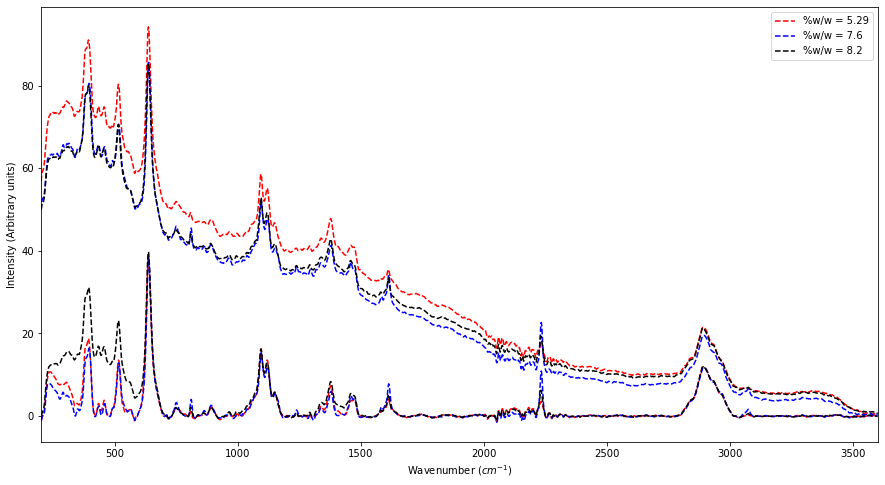

In [18]:
plt.figure(figsize=(15,8))
plt.plot(spectra.wavenumbers, spectra.intensity[0], "--", label=f"%w/w = {round(to_predict[0], 2)}", color="r")
plt.plot(spectra.wavenumbers, spectra.intensity[55], "--", label=f"%w/w = {round(to_predict[55], 2)}", color="b")
plt.plot(spectra.wavenumbers, spectra.intensity[90], "--", label=f"%w/w = {round(to_predict[90], 2)}", color="black")
axes = plt.gca()
axes.set_xlim([200,3601])
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (Arbitrary units)")

# Pre-processing
start_time = time.time()
ROI = np.array([[200, 300], [700, 1000], [1600, 2000], [2250, 2700], [3100, 3600]])
spectra.removeBaseline(roi=ROI, method="drPLS", inplace=True, **{"ratio": 1e-4, "niter": 10000})
print("--- %s seconds ---" % (time.time() - start_time))
spectra.smoothSignal(inplace=True)

plt.plot(spectra.wavenumbers, spectra.intensity[0], "--", color="r")
plt.plot(spectra.wavenumbers, spectra.intensity[55], "--", color="b")
plt.plot(spectra.wavenumbers, spectra.intensity[90], "--", color="black")
plt.legend()
plt.savefig("tablets_results_raw_preprocessing.png", dpi=300, bbox_inches="tight", pad_inches=0)

### Select best regressor
The following step is to see which of the regressors, Ridge or PLS, after performing scaling, yields the best results.

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

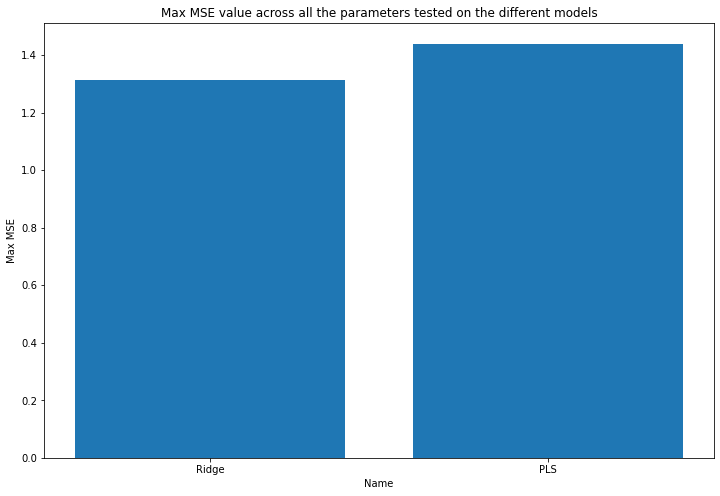

In [8]:
spectra.testRegressors(to_predict, True)

### Train the model
The model with the best hyperparameters were selected from the step before using cross-validation. Now, the different metrics are presented by finally using the model.

Metrics: 
RMSECV = 0.8 
R2 = 0.65 
R coefficient = 0.8


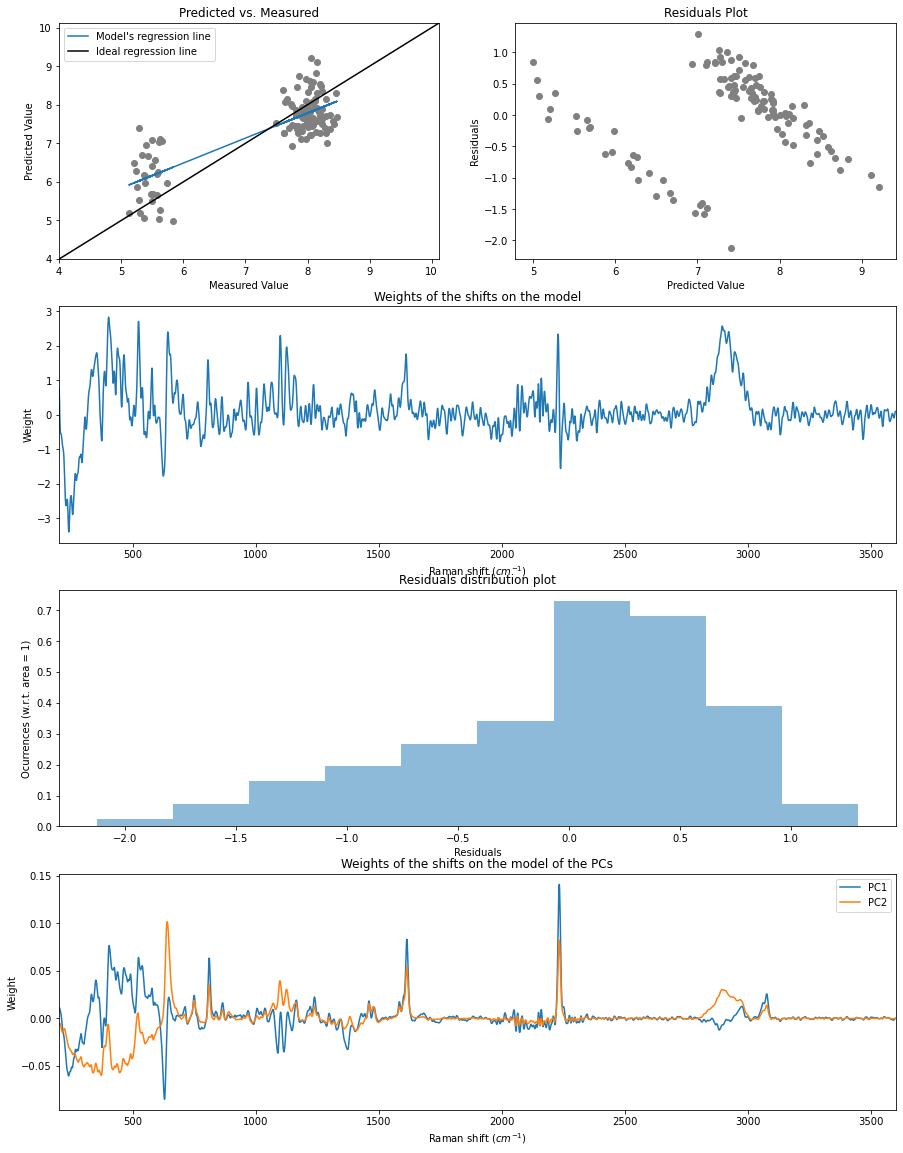

In [11]:
# Train best model
results = spectra.trainModel(to_predict, True)